# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

np.random.seed(2606)

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

def build_datasets(train, valid, test):
    '''
    Convenience function to build or rebuild all 3 datasets from orignal pickles.
    '''
    X_train, y_train = np.array(train['features']), np.array(train['labels'])
    X_valid, y_valid = np.array(valid['features']), np.array(valid['labels'])
    X_test, y_test = np.array(test['features']), np.array(test['labels'])
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = build_datasets(train, valid, test)

# Step 1: Generate additional data

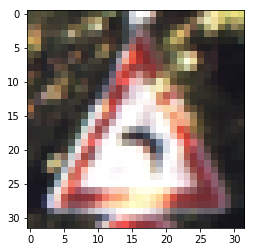

In [2]:
plt.figure(figsize = (4, 4))
plt.imshow(X_train[6768])

In [3]:
import copy

VARIATIONS = 4  # Number of fake images to generate for each real one

def jitter_image(x):
    '''
    Takes an image and returns a jittered version of it by applying random
    scaling, translation and rotation.
    
    x: an image array
    
    '''
        
    # Scale by a random factor between .85 and 1.15
    scaling_x = 0.3 * np.random.sample() + 0.85
    scaling_y = 0.3 * np.random.sample() + 0.85 
    img = cv2.resize(x, dsize = (0, 0), fx = scaling_x, fy = scaling_y)
    
    # Restore original array size by adding padding
    s_y, s_x = x[:,:,0].shape  # Get new shape after resizing
    y_padding = round(32 - s_y)
    x_padding = round(32 - s_x)
    x = cv2.copyMakeBorder(x, y_padding, y_padding, x_padding, x_padding, 
                             cv2.BORDER_WRAP)
     
    # Translate by a random number of pixels between -2 and +2
    trans_x = 4. * np.random.sample() - 2
    trans_y = 4. * np.random.sample() - 2
    M_trans = np.float32([[1, 0, trans_x], [0, 1, trans_y]])  # Define translation matrix
    x = cv2.warpAffine(x, M = M_trans, dsize = (32, 32),  # Apply translation
                       borderMode = cv2.BORDER_WRAP)
    
    # Rotate by a random angle between -10 and +10 degrees
    rot_deg = 20 * np.random.sample() - 10
    M_rot = cv2.getRotationMatrix2D((round(s_x / 2), round(s_y / 2)), rot_deg, 1) # Define rot. matrix
    x = cv2.warpAffine(x, M = M_rot, dsize = (s_x, s_y),  # Apply rotation
                       borderMode = cv2.BORDER_WRAP)    

    return x


def adjust_channels(x):
    '''
    Takes an image and applies a different adjustment to each channel 
    sampled from the interval [.95, 1.05]. Returns the modified image.
    
    x: an image array
    '''
    for chan in range(x.shape[2]):
        adj_coeff = 1. + np.random.randn() * 0.05
        lower = np.zeros_like(x[:,:, chan])
        upper = np.zeros_like(x[:,:, chan]) + 255
        x[:,:, chan] = np.maximum(lower, x[:,:, chan] * adj_coeff)
        x[:,:, chan] = np.minimum(x[:,:, chan], upper)
    return x


def create_images(x, y):
    '''
    Takes a single image as input and produces 5 variations with random
    jittering and channel adjustments.
    
    x: Single image (a 3-dimensional np.ndarray))
    variations: How many jittered / colour-adjusted copies of the original
                image to return?
            
    Returns: An 4d-array of stacked images such that x_out.shape[0] == variations
    '''
    x_out = np.array([adjust_channels(jitter_image(x)) for img in range(VARIATIONS)])
    y_out = np.array([y for img in range(VARIATIONS)])  # Don't change y but replicate each value
    return x_out, y_out


# Apply this process to all images in the training set:
X_train_fake = np.concatenate([fake_x for fake_x in map(lambda x, y: create_images(x, y)[0], 
                                                        X_train, y_train)], 0)
y_train_fake = np.concatenate([fake_x for fake_x in map(lambda x, y: create_images(x, y)[1], 
                                                        X_train, y_train)], 0)

# Concatenate to existing training set
X_train = np.concatenate((X_train, X_train_fake), 0)
y_train = np.concatenate((y_train, y_train_fake), 0)

In [4]:
with open('./data/x_train_with_fakes.p', mode = 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/y_train_with_fakes.p', mode = 'wb') as f:
    pickle.dump(y_train, f)
with open('./data/x_valid.p', mode= 'wb') as f:
    pickle.dump(X_valid, f)
with open('./data/y_valid.p', mode= 'wb') as f:
    pickle.dump(y_valid, f)
with open('./data/x_test.p', mode= 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/y_test.p', mode= 'wb') as f:
    pickle.dump(y_test, f)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# Number of validation examples:
n_valid = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[np.random.randint(0, n_train)].shape[:2]  # Select a random image

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 173995
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

 * **First, look at a few random images from the training set:**
 
 Note that these images are from the original data (no jittering or colour adjustment).

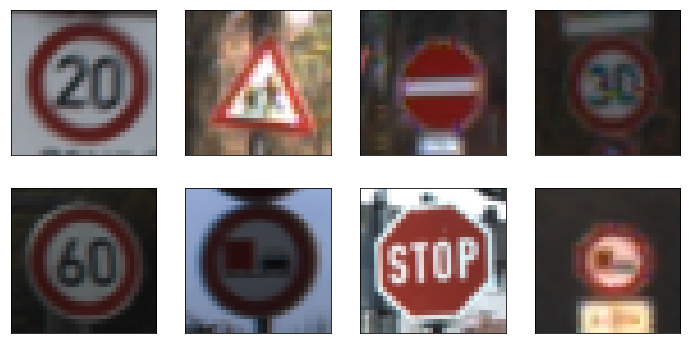

In [7]:
rand_images = np.random.randint(0, n_train / 5, size = 8)
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(train['features'][rand_images[i]])

It seems that some of the signs, especially those with digits on them, might be challenging due to the low image resolution and lighting conditions.

* **Count of each sign:**

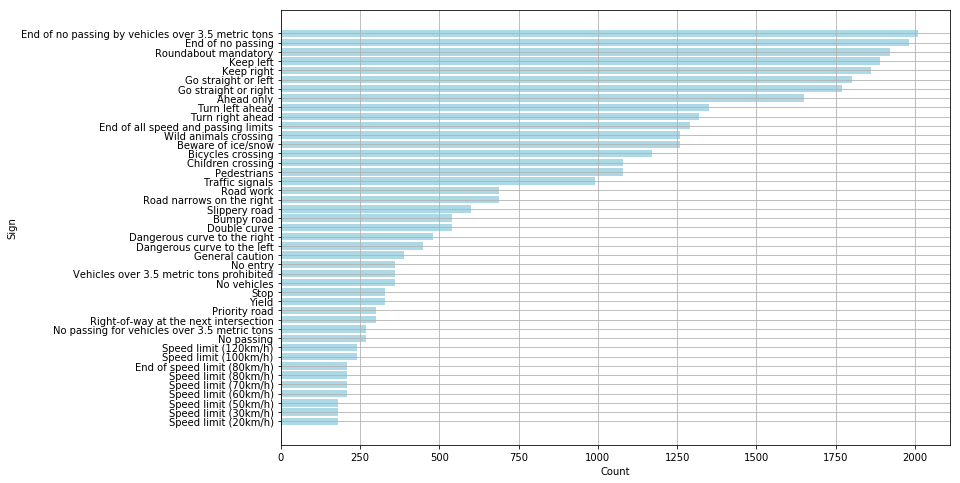

In [8]:
# First import the sign id mapping and make a data frame for the training set:
sign_labels = pd.DataFrame(train['labels'], columns = ['labels'])
sign_names = pd.read_csv('signnames.csv', index_col = 'ClassId')
signs_train = pd.DataFrame(train['features'][:, 0, 0, 0], 
                           columns = ['num_example'])
signs_train = pd.concat([signs_train, sign_labels], axis = 1)
signs_train = signs_train.join(sign_names, on = 'labels')

signs_train_grp = signs_train.groupby(['labels', 'SignName'], 
                                      as_index = False).count().sort_values('num_example', 
                                                                            ascending = True)

plt.figure(figsize = (12, 8))    
plt.barh(signs_train_grp['labels'], signs_train_grp['num_example'], color = 'lightblue')
plt.xlabel('Count')
plt.ylabel('Sign')
plt.yticks(signs_train_grp['labels'], signs_train_grp['SignName'])
plt.grid(True)
plt.show()


Unfortunately the signs that we believe might be the harder to predict correctly (speed limit signs) are also the rarest in the dataset.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from copy import copy


In [10]:
# Conversions to different colour maps

def convert_to_grey(x):
    '''
    Converts a collection of images (stored as a single np.ndarray, axis 0 denoting the
    index within the collection) to greyscale.
    Returns a collection of 1-channel images of same dimensions.
    
    x: a 3-channel array
    '''
    x_out = np.zeros((x.shape[0], x.shape[1], x.shape[2], 1))
    for i in range(x_out.shape[0]):
        x_out[i, : , : , 0] = cv2.cvtColor(x[i, : , : , :], cv2.COLOR_RGB2GRAY)
    return x_out

def convert_to_hls_drop_2(x):
    '''
    Converts a collection of images (stored as a single np.ndarray, axis 0 denoting the
    index within the collection) to HLS and drops the H and S channels.
    Returns a collection of 1-channel image of same dimensions.
    
    x: a 3-channel array
    '''
    x_out = np.zeros((x.shape[0], x.shape[1], x.shape[2], 1))
    for i in range(x_out.shape[0]):
        x_out[i, : , : , 0] = cv2.cvtColor(x[i, : , : , :], cv2.COLOR_RGB2HLS)[: , :, 1]
    return x_out

def convert_to_colorspace_3(x, code):
    '''
    Converts a collection of images (stored as a single np.ndarray, axis 0 denoting the
    index within the collection) to another 3-channel colourspace.
    Returns a collection of 3-channel image of same dimensions.
    
    x: a 3-channel array
    '''
    x_out = np.zeros_like(x)
    for i in range(x_out.shape[0]):
        x_out[i] = cv2.cvtColor(x[i], code)
    return x_out

#X_train = convert_to_grey(X_train)
#X_valid = convert_to_grey(X_valid)
#X_test = convert_to_grey(X_test)
#X_train = convert_to_hls_drop_2(X_train)
#X_valid = convert_to_hls_drop_2(X_valid)
#X_test = convert_to_hls_drop_2(X_test)
#X_train = convert_to_colorspace_3(X_train, cv2.COLOR_RGB2YCrCb)
#X_valid = convert_to_colorspace_3(X_valid, cv2.COLOR_RGB2YCrCb)
#X_test = convert_to_colorspace_3(X_test, cv2.COLOR_RGB2YCrCb)

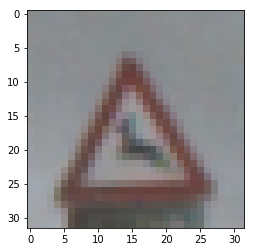

In [11]:
plt.imshow(X_train[546])  # Display an image

In [ ]:
with open('./data/x_train_with_fakes.p', mode = 'rb') as f:
    X_train = pickle.load(f)
with open('./data/y_train_with_fakes.p', mode = 'rb') as f:
    y_train = pickle.load(f)
with open('./data/x_valid.p', mode= 'rb') as f:
    X_valid = pickle.load(f)
with open('./data/y_valid.p', mode= 'rb') as f:
    y_valid = pickle.load(f)
with open('./data/x_test.p', mode= 'rb') as f:
    X_test = pickle.load(f)
with open('./data/y_test.p', mode= 'rb') as f:
    y_test = pickle.load(f)

In [12]:
# Normalisation:

def normalize_per_image(x):
    channels = x.shape[3]
    x_out = np.zeros_like(x, dtype = np.float32)
    for index, img in enumerate(x):
        x_out[index] = cv2.normalize(img, x_out[index], alpha = -1, beta = 1, 
                      norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    return x_out

def center_global(x):
    x_out = np.zeros_like(x, dtype = np.float64)
    mean_img = np.mean(x, axis = 0, dtype = np.float64, keepdims = True)
    x_out = x - mean_img
    
    return x_out

def center_per_channel(x):
    x_out = np.zeros_like(x, dtype = np.float64)
    
    for c in range(x.shape[3]):  # Apply zero centering by channel
        x_out[:,:,:,c] = x[:,:,:,c] - np.mean(x[:,:,:,c], dtype = np.float64, keepdims = True)
    
    return x_out

X_train = normalize_per_image(X_train)
X_valid = normalize_per_image(X_valid)
X_test = normalize_per_image(X_test)

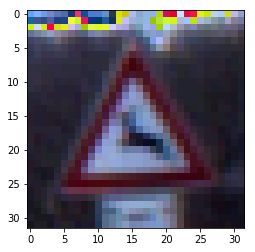

In [13]:
plt.imshow(X_train[651,:,:,:])

### Model Architecture

In [14]:
from tensorflow.contrib.layers import flatten

# ConvNet filter and stride sizes:
cv1_fsize, cv1_stride = 5, 1
pl1_ksize, pl1_stride = 2, 2
cv2_fsize, cv2_stride = 5, 1
pl2_ksize, pl2_stride = 2, 2
    

def LeNet(x, keep_prob, n_channels = 1):    
    '''
    Defines the ConvNet's architecture.
    '''
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    epsilon = 1.e-3

    # Define weight variables:
    weights = {
        'cv1_w': tf.Variable(tf.truncated_normal([cv1_fsize, cv1_fsize, n_channels, 6], mu, sigma)),
        'bn1_a': tf.Variable(tf.ones([6])),
        'cv2_w': tf.Variable(tf.truncated_normal([cv2_fsize, cv2_fsize, 6, 16], mu, sigma)),
        'bn2_a': tf.Variable(tf.ones([16])),
        'fc3_w': tf.Variable(tf.truncated_normal([400, 120], mu, sigma)),
        'fc4_w': tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
        'fc5_w': tf.Variable(tf.truncated_normal([84, 43], mu, sigma))
    }
    biases = {
        'cv1_b': tf.Variable(tf.truncated_normal([6])),
        'bn1_b': tf.Variable(tf.zeros([6])),
        'cv2_b': tf.Variable(tf.truncated_normal([16])),
        'bn2_b': tf.Variable(tf.zeros([16])),
        'fc3_b': tf.Variable(tf.truncated_normal([120], mu, sigma)),
        'fc4_b': tf.Variable(tf.truncated_normal([84], mu, sigma)),
        'fc5_b': tf.Variable(tf.truncated_normal([43], mu, sigma))
    }
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    cv1 = tf.nn.conv2d(x, weights['cv1_w'], strides = [1, cv1_stride, cv1_stride, 1], 
                       padding = 'VALID')  # No need for bias with batch normalization
    # Batch normalization
    bn_mean1, bn_var1 = tf.nn.moments(cv1, axes = [0])
    bn1 = tf.nn.batch_normalization(cv1, bn_mean1, bn_var1, biases['bn1_b'], weights['bn1_a'],
                                   epsilon)
    # Activation.
    ac1 = tf.nn.relu(bn1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pl1 = tf.nn.max_pool(ac1, ksize = [1, pl1_ksize, pl1_ksize, 1], 
                         strides = [1, pl1_stride, pl1_stride, 1], padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    cv2 = tf.nn.conv2d(pl1, weights['cv2_w'], strides = [1, cv2_stride, cv2_stride, 1],
                       padding = 'VALID')
    
    # Batch normalization
    bn_mean2, bn_var2 = tf.nn.moments(cv2, axes = [0])
    bn2 = tf.nn.batch_normalization(cv2, bn_mean2, bn_var2, biases['bn2_b'], weights['bn2_a'],
                                   epsilon)
    
    # Activation.
    ac2 = tf.nn.relu(bn2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pl2 = tf.nn.max_pool(ac2, ksize = [1, pl2_ksize, pl2_ksize, 1],
                         strides= [1, pl2_stride, pl2_stride, 1], padding = 'VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(pl2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = tf.add(tf.matmul(flat, weights['fc3_w']), biases['fc3_b'])
    
    # Activation.
    ac3 = tf.nn.relu(fc3)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4 = tf.add(tf.matmul(ac3, weights['fc4_w']), biases['fc4_b'])
    
    # Activation.
    ac4 = tf.nn.relu(fc4)
    
    # Dropout:
    do4 = tf.nn.dropout(ac4, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(do4, weights['fc5_w']), biases['fc5_b'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Number of channels:
chan = X_train.shape[3]
print("Each image has {} channel(s)".format(chan))
# Meta-parameters:
EPOCHS = 200
BATCH_SIZE = 128
rate = 0.001
TARGET = 0.97

x = tf.placeholder(tf.float32, (None, 32, 32, chan))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

logits = LeNet(x, keep_prob, chan)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    train_accuracies = []
    valid_accuracies = []
    
    print("Training...")
    print()
    i = 0
    
    while True:
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.4})
        
        training_accuracy = evaluate(X_train, y_train)    
        validation_accuracy = evaluate(X_valid, y_valid)
        
        train_accuracies.append(training_accuracy)
        valid_accuracies.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        i += 1
        if validation_accuracy >= TARGET or i + 1 >= EPOCHS:
            break
        
    saver.save(sess, './lenet')
    print("Model saved")

In [ ]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.plot(valid_accuracies, c = 'b')
ax.plot(train_accuracies, c = 'g')
plt.ylim(0.8, 1.)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 